In [53]:
import numpy as np
import pandas as pd
import os
assayfile = 'CDK2_CHEMBL301_IC50_2763bioactivity.csv'
df = pd.read_csv(assayfile, delimiter=';')
df = df.replace(to_replace='None', value=np.nan)
print(df.columns)
print(df.shape)

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')
(2763, 45)


In [54]:
subdf = df[['Molecule ChEMBL ID', 'Molecular Weight', '#RO5 Violations', \
    'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units']]
subdf.describe(include='all')

Molecule ChEMBL ID Molecular Weight #RO5 Violations  \
count                2763             2759            2752   
unique               2312             1547               4   
top           CHEMBL14762           488.64               0   
freq                   12               18            2322   
mean                  NaN              NaN             NaN   
std                   NaN              NaN             NaN   
min                   NaN              NaN             NaN   
25%                   NaN              NaN             NaN   
50%                   NaN              NaN             NaN   
75%                   NaN              NaN             NaN   
max                   NaN              NaN             NaN   

                                              Smiles Standard Type  \
count                                           2758          2763   
unique                                          2309             1   
top     CC[C@H](CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1          IC50   
freq                                              12          2763   
mean                                             NaN           NaN   
std                                              NaN           NaN   
min                                              NaN           NaN   
25%                                              NaN           NaN   
50%                                              NaN           NaN   
75%                                              NaN           NaN   
max                                              NaN           NaN   

       Standard Relation  Standard Value Standard Units  
count               2721    2.725000e+03           2727  
unique                 3             NaN              3  
top                  '='             NaN             nM  
freq                2007             NaN           2674  
mean                 NaN    2.696660e+04            NaN  
std                  NaN    1.156859e+05            NaN  
min                  NaN    1.000000e-01            NaN  
25%                  NaN    4.300000e+01            NaN  
50%                  NaN    7.890000e+02            NaN  
75%                  NaN    1.000000e+04            NaN  
max                  NaN    1.230000e+06            NaN

## Clean up dataset

- Remove molecules without `Smiles`
- Remove molecules that violates `#RO5 Violations`
- Fix `Standard Units`:
    + Remove `nan`
    + Adjust `µM` to `nM`: *1000
    + Adjust `ug.mL-1` to `nM`: 
        - Convert to `mol` using `Molecular Weight` or `Smiles`
        - Convert to `L`

Remove molecules without SMILES

In [55]:
subdf = df.drop_duplicates(subset=['Molecule ChEMBL ID'])
print(subdf.shape)
sele_df = subdf[~subdf['Standard Units'].isna()]
print(sele_df.shape)
sele_df = sele_df[~sele_df['Smiles'].isna()]
print(sele_df.shape)

(2312, 45)
(2278, 45)
(2275, 45)


Adjust IC50 values

In [56]:
subdf['Standard Units'].unique()

array(['nM', nan, 'ug.mL-1', 'µM'], dtype=object)

In [57]:
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors
def adjust_ug_ml(x):
    if x['Standard Units']=='ug.mL-1':
        mw = Descriptors.MolWt(Chem.MolFromSmiles(x['Smiles']))
        tmp = x['Standard Value'] / mw * 10**6
        return tmp
    else:
        return x['Standard Value']

In [58]:
sele_df = sele_df[~sele_df['Standard Value'].isna()]
sele_df['Standard Value'] = sele_df['Standard Value'].astype('float')
sele_df['Adjusted_IC50'] = sele_df.apply(lambda x: x['Standard Value']*1000 if x['Standard Units']=='µM' \
                                else x['Standard Value'], axis=1)
sele_df['Adjusted_IC50'] = sele_df.apply(lambda x: adjust_ug_ml(x), axis=1)
sele_df = sele_df.drop(['Standard Units'], axis=1)
print(sele_df.shape)

(2274, 45)


## Output SMILES and IC50 values

In [59]:
sele_df['Standard Relation'].unique()

array(["'='", "'>'", "'<'", nan], dtype=object)

In [60]:
sele_df = sele_df[~sele_df['Standard Relation'].isna()]
print(sele_df.shape)

(2270, 45)


In [61]:
eq_df = sele_df[sele_df['Standard Relation'].str.contains('=')]
for idx, row in eq_df.iterrows():
    print(row['Molecule ChEMBL ID'], row['Smiles'], row['Adjusted_IC50'])
    break
print(eq_df.shape)

CHEMBL189963 CC(=O)c1c(C)c2cnc(Nc3ccc(N4CCNCC4)cn3)nc2n(C2CCCC2)c1=O 10.0
(1600, 45)


In [62]:
with open('cleaned_bioactivities.txt', 'w') as file:
    eq_df = sele_df[sele_df['Standard Relation'].str.contains('=')]
    for idx, row in eq_df.iterrows():
        file.write(row['Molecule ChEMBL ID'] \
            +','+row['Smiles'] \
            +','+f"{row['Adjusted_IC50']:.5f}"+os.linesep)

<Figure size 1000x1000 with 0 Axes>

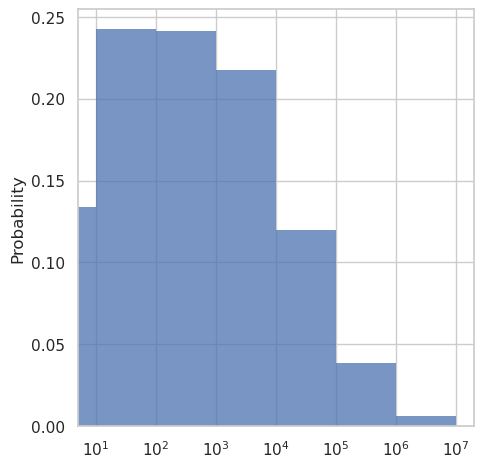

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 24
plt.rcParams['lines.linewidth'] = 3
custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(style="whitegrid", rc=custom_params)
plt.figure(figsize=(10, 10))
bins = [0, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7]
normal_ic50 = sele_df[sele_df['Standard Relation'].str.contains('=')]['Adjusted_IC50'].values
sns.displot(normal_ic50, bins=bins, stat='probability', facet_kws=dict(despine=False), )
plt.xscale('log')
plt.axis('on')
ax = plt.gca()
ax.tick_params(direction='out', length=6, width=2)

In [64]:
len(normal_ic50)

1600

## Download Mol Files
Using openbabel to create 3D sdf files from SMILES takes a lot of time.
- Use RDKit to generate 3D molecule structures
- Use ChEMBL web service to download molecular files.
[ChEMBL Web API](https://www.ebi.ac.uk/chembl/api/data/docs)

In [65]:
todolist = []
with open('cleaned_bioactivities.txt', 'r') as file:
    for line in file.readlines():
        ligname, ligsmi, ligaff = line.strip().split(',')
        todolist.append((ligname, ligsmi))

In [66]:
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
outdir = './compounds'
if not os.path.exists(outdir):
    os.makedirs(outdir, exist_ok=True)

for ligname, ligsmi in todolist:
    sdffile = os.path.join(outdir, f'{ligname}.sdf')
    if os.path.exists(sdffile):
        continue
    mol = Chem.MolFromSmiles(ligsmi)
    if mol is None:
        print(ligname, ligsmi)
    else:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        Chem.MolToMolFile(mol, sdffile)

## Split activated CDK2 and inactivated CDK2 bioassays

In [67]:
cleaned_entries = []
with open('cleaned_bioactivities.txt', 'r') as file:
    for line in file.readlines():
        ligname, ligsmi, ligaff = line.strip().split(',')
        cleaned_entries.append((ligname, ligsmi, ligaff))
cleaned_names = [entry[0] for entry in cleaned_entries]
print('Number of compounds after clean-up datatset:', len(cleaned_names))

Number of compounds after clean-up datatset: 1600


In [68]:
cleaned_mask = subdf.apply(lambda x: x['Molecule ChEMBL ID'] in cleaned_names, axis=1)
cleaned_df = subdf[cleaned_mask]
print('Shape of cleaned data:', cleaned_df.shape)
print(len(cleaned_df['Assay Description'].unique()))
with open('cleaned_bioassay_descriptions.txt', 'w') as file:
    desc = cleaned_df['Assay Description'].unique()
    file.write(os.linesep.join(desc))

Shape of cleaned data: (1600, 45)
100


Manually split 'Assay Description' to `activated CDK2 descriptions` and `inactivated CDK2 descriptions`:
- `cleaned_activated_CDK2_bioassay_descriptions.txt`
- `cleaned_inactivated_CDK2_bioassay_descriptions.txt`

In [69]:
with open('cleaned_activated_CDK2_bioassay_descriptions.txt', 'r') as file:
    activated_desc = [line.strip() for line in file.readlines()]
with open('cleaned_inactivated_CDK2_bioassay_descriptions.txt', 'r') as file:
    inactivated_desc = [line.strip() for line in file.readlines()]

def is_activated(x):
    description = x['Assay Description']
    if description.strip() in activated_desc:
        return True
    else:
        return False

def is_inactivated(x):
    description = x['Assay Description']
    if description.strip() in inactivated_desc:
        return True
    else:
        return False

activated_mask = cleaned_df.apply(lambda x: is_activated(x), axis=1)
inactivated_mask = cleaned_df.apply(lambda x: is_inactivated(x), axis=1)
activated_df = cleaned_df[activated_mask]
inactivated_df = cleaned_df[inactivated_mask]
print('Number of activated CDK2 assays:', activated_df.shape[0])
print('Number of inactivated CDK2 assays:', inactivated_df.shape[0])

Number of activated CDK2 assays: 517
Number of inactivated CDK2 assays: 1082


In [71]:
activated_names = activated_df['Molecule ChEMBL ID'].tolist()
activated_entries = []
with open('cleaned_activated_cdk2_bioactivities.txt', 'w') as file:
    for entry in cleaned_entries:
        ligname, ligsmi, ligaff = entry
        if ligname in activated_names:
            file.write(ligname+','+ligsmi+','+ligaff+os.linesep)
            activated_entries.append(entry)
print('Number of activated CDK2 IC50:', len(activated_entries))

Number of activated CDK2 IC50: 517


In [72]:
inactivated_names = inactivated_df['Molecule ChEMBL ID'].tolist()
inactivated_entries = []
with open('cleaned_inactivated_cdk2_bioactivities.txt', 'w') as file:
    for entry in cleaned_entries:
        ligname, ligsmi, ligaff = entry
        if ligname in inactivated_names:
            file.write(ligname+','+ligsmi+','+ligaff+os.linesep)
            inactivated_entries.append(entry)
print('Number of inactivated CDK2 IC50:', len(inactivated_entries))

Number of inactivated CDK2 IC50: 1082


## Further Filter Compounds by Properties

In [73]:
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors

In [74]:
subset_activated_entries = []
minset_activated_entries = []
with open('cleaned_activated_cdk2_bioactivities.txt', 'r') as file:
    for line in file.readlines():
        ligname, ligsmi, ligaff = line.strip().split(',')
        ligaff = float(ligaff)
        if ligaff <= 10 or ligaff > 10000:
            subset_activated_entries.append(line)
            lig = Chem.MolFromSmiles(ligsmi)
            mw = Descriptors.MolWt(lig)
            if mw >= 400:
                minset_activated_entries.append(line)
print('Number of compounds for activated CDK2 with IC50<10 or >10000:', len(subset_activated_entries))
print('Number of compounds for activated CDK2 with IC50<10 or >10000 and desired molecular weight:', len(minset_activated_entries))

with open('cleaned_activated_cdk2_bioactivities_subset.txt', 'w') as file:
    for line in subset_activated_entries:
        file.write(line)

with open('cleaned_activated_cdk2_bioactivities_minset.txt', 'w') as file:
    for line in minset_activated_entries:
        file.write(line)

Number of compounds for activated CDK2 with IC50<10 or >10000: 153
Number of compounds for activated CDK2 with IC50<10 or >10000 and desired molecular weight: 45


In [75]:
subset_inactivated_entries = []
minset_inactivated_entries = []
with open('cleaned_inactivated_cdk2_bioactivities.txt', 'r') as file:
    for line in file.readlines():
        ligname, ligsmi, ligaff = line.strip().split(',')
        ligaff = float(ligaff)
        if ligaff <= 10 or ligaff > 10000:
            subset_inactivated_entries.append(line)
            lig = Chem.MolFromSmiles(ligsmi)
            mw = Descriptors.MolWt(lig)
            if mw >= 400:
                minset_inactivated_entries.append(line)

print('Number of compounds for inactivated CDK2 with IC50<10 or >10000:', len(subset_inactivated_entries))
print('Number of compounds for inactivated CDK2 with IC50<10 or >10000 and desired molecular weight:', len(minset_inactivated_entries))

with open('cleaned_inactivated_cdk2_bioactivities_subset.txt', 'w') as file:
    for line in subset_inactivated_entries:
        file.write(line)

with open('cleaned_inactivated_cdk2_bioactivities_minset.txt', 'w') as file:
    for line in minset_inactivated_entries:
        file.write(line)

Number of compounds for inactivated CDK2 with IC50<10 or >10000: 323
Number of compounds for inactivated CDK2 with IC50<10 or >10000 and desired molecular weight: 164
